In [209]:
import json
import re
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix
# from sklearn.svm import LinearSVC
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import fasttext

In [210]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [211]:
device

device(type='cuda')

In [212]:
ft = fasttext.load_model('/kaggle/input/nlp-project-embeding/indicnlp.ft.hi.300.bin')

In [213]:
def feature_transform(train_file):
    
    f = open(train_file, encoding='utf-8')

    y = []
    data = []
 
    
    

    for line in f:
#             ctr += 1
            row=[]
            if(line.rstrip()):
                line = re.sub("\s+"," ",line)
                line1 = line.split(";")
                # print(line1.encode('utf-8'))
                # for line2 in line1:
                #     line2=line2.encode('utf-8')
                #     print(line2.decode('utf-8'))
                a3 = line1[2].split(" ")
                a2 = line1[1].split(" ")
                a1 = line1[0].split(" ")
                y.append(a3[1])
                
                

                if(a1[0] == "ROOT"):
                    row.append('ROOT')
                    row.append('ROOT')
                

                elif(a1[0] == "H"):
                    row.append(a1[1])
                    row.append(a1[3])

                row.append(a2[2])
                row.append(a2[4])
                data.append(row)

    f.close()

    return data, y


In [ ]:
train_file = './data/parsed_output_train.txt'
test_file = "./data/parsed_output_test.txt"

In [214]:
listfile = "./data/data_list.json"
f = open(listfile, encoding='utf-8')
data = json.load(f)
f.close()

tags = data["tags"]
chunk_tags = data["chunk_tags"]

chunk_tags_len = len(chunk_tags)

In [215]:
# def one_hot_encode(X_train, num_unique_values):
#     x_onehot = []
#     # Iterate over each sublist in X
#     for sublist in X_train:
#         sublist_onehot = []  # Initialize an empty list for one-hot encodings of the sublist
#         # Iterate over each value in the sublist
#         for value in sublist:
#             # Create one-hot encoding for the value
           
#             onehot_value = np.eye(num_unique_values)[value]  # Create one-hot encoding for the value
#             sublist_onehot.append(onehot_value)  # Append the one-hot encoding to the sublist_onehot list
#         x_onehot.append(sublist_onehot)
#     return x_onehot

In [216]:

def find_embedding(X_train,ft):
    x_embided = []
    
    for sublist in X_train:
        sublist_onehot = []  # Initialize an empty list for one-hot encodings of the sublist
        # Iterate over each value in the sublist
        for value in sublist:
            # Create one-hot encoding for the value
            word_embed=ft.get_word_vector(value)[:100]  
            sublist_onehot.append(word_embed)  # Append the one-hot encoding to the sublist_onehot list
        x_embided.append(sublist_onehot)
    return x_embided
    
    
# Load the FastText model


In [217]:




    
    
    
class FFNN(nn.Module):
    def __init__(self, embedding_dim,hidden_dim, output_dim):
        super(FFNN, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.input_dim = embedding_dim * (4)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, inputs):
        x = inputs.view(-1, self.input_dim)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model


In [218]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Plot the training loss
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

In [219]:
def evaluate_model(model, test_loader, device):
    with torch.no_grad():
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_x)

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Append true and predicted labels
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Total number of labels
            total += batch_y.size(0)

            # Total correct predictions
            correct += (predicted == batch_y).sum().item()

        test_accuracy = 100 * correct / total
        return y_true, y_pred, test_accuracy

In [220]:
def plot_classification_matrix(y_true, y_pred, labels):
    try:
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.set(font_scale=1.2)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Classification Matrix')
        plt.show()
    except ValueError as e:
        print(e)

def print_classification_report(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))

In [221]:
X_train, y_train = feature_transform(train_file,)

X_test, y_test = feature_transform(test_file)


In [222]:
print(y_train[0:10])

['R', 'R', 'R', 'L', 'L', 'U', 'U', 'U', 'U', 'U']


In [223]:
print(X_train[0:10])

[['एशिया', 'NP', 'मस्जिदों', 'NP'], ['मस्जिदों', 'NP', 'है', 'VGF'], ['एक', 'NP', 'है', 'VGF'], ['ROOT', 'ROOT', 'है', 'VGF'], ['है', 'VGF', '।', 'BLK'], ['मस्जिदों', 'NP', 'एक', 'NP'], ['एशिया', 'NP', 'है', 'VGF'], ['एक', 'NP', '।', 'BLK'], ['मस्जिदों', 'NP', '।', 'BLK'], ['एशिया', 'NP', '।', 'BLK']]


In [224]:
# Define your data
# X_train=np.array(X_train)
num_unique_values=10
X_train_embed = find_embedding(X_train,ft)  # Append the sublist_onehot list to the x_onehot list

X_test_embed = find_embedding(X_test, ft)
# Convert x_onehot to a numpy array
X_train = np.array(X_train_embed)
X_test = np.array(X_test_embed)
print(X_train[0])
print(X_train[1])


[[-9.63710696e-02  1.88151374e-01  2.86658823e-01  1.29208356e-01
   3.91100436e-01  1.75929800e-01 -1.61514461e-01  1.45212114e-01
   3.63088429e-01  2.04414770e-01  2.97474116e-02 -1.64313555e-01
  -5.58175407e-02  5.86120002e-02 -1.11262366e-01  3.78761292e-01
  -5.54021746e-02 -2.85908312e-01  2.43109941e-01  3.70252552e-03
   9.95736495e-02  2.25103110e-01 -4.75492686e-01 -7.88841471e-02
  -1.49099957e-02  4.64612603e-01  3.34295541e-01  7.74242803e-02
  -2.57707536e-01  2.37564147e-01  2.81373471e-01 -1.91286162e-01
  -1.08131588e-01  1.20784134e-01  4.38966267e-02  2.85405487e-01
   1.91355526e-01  1.44090444e-01  6.75462857e-02 -1.28808409e-01
   2.22796634e-01 -1.53911412e-01  3.44482958e-01  3.31839830e-01
   1.23297766e-01 -1.63077995e-01  1.53266951e-01  2.14429006e-01
   3.55777055e-01 -2.42270883e-02  2.35426441e-01  9.04780552e-02
  -2.94032454e-01 -9.33565348e-02  1.68551490e-01  2.19389156e-01
   2.07102358e-01 -9.63925719e-02  3.02235961e-01  6.86980924e-03
  -2.33394

In [225]:
label_dict = {'R': 0, 'L': 1, 'U': 2}
y_numerical = np.array([label_dict[label] for label in y_train])

# Convert data to PyTorch tensors
x_tensor_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_tensor_train = torch.tensor(y_numerical, dtype=torch.long).to(device)


In [226]:
y_numerical_test = np.array([label_dict[label] for label in y_test])

# Convert data to PyTorch tensors
x_tensor_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_tensor_test = torch.tensor(y_numerical_test, dtype=torch.long).to(device)

In [227]:
print(x_tensor_test.shape)
print(y_tensor_test.shape)

torch.Size([36141, 4, 100])
torch.Size([36141])


In [228]:
train_dataset = TensorDataset(x_tensor_train, y_tensor_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [229]:
test_dataset = TensorDataset(x_tensor_test, y_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=1)

In [230]:
print(len(train_loader))

8465


In [231]:


input_size = len(X_train[0][0])  # Number of features after one-hot encoding
print(input_size)
hidden_size = 64  # Number of units in the hidden layer
num_classes = 3  # Number of output classes
num_epochs=10
model = FFNN(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop


100


 10%|█         | 1/10 [00:13<02:04, 13.87s/it]

Epoch 1/10, Loss: 0.33268512512496146


 20%|██        | 2/10 [00:27<01:50, 13.81s/it]

Epoch 2/10, Loss: 0.3306501703102491


 30%|███       | 3/10 [00:41<01:37, 13.87s/it]

Epoch 3/10, Loss: 0.32901379247864393


 40%|████      | 4/10 [00:55<01:23, 13.83s/it]

Epoch 4/10, Loss: 0.3271023233799067


 50%|█████     | 5/10 [01:09<01:09, 13.84s/it]

Epoch 5/10, Loss: 0.32547317250410057


 60%|██████    | 6/10 [01:22<00:55, 13.81s/it]

Epoch 6/10, Loss: 0.32436284531970666


 70%|███████   | 7/10 [01:36<00:41, 13.81s/it]

Epoch 7/10, Loss: 0.3232306408938472


 80%|████████  | 8/10 [01:50<00:27, 13.82s/it]

Epoch 8/10, Loss: 0.3217359314145101


 90%|█████████ | 9/10 [02:04<00:13, 13.79s/it]

Epoch 9/10, Loss: 0.3207618730198823


100%|██████████| 10/10 [02:18<00:00, 13.83s/it]

Epoch 10/10, Loss: 0.31976231735395527


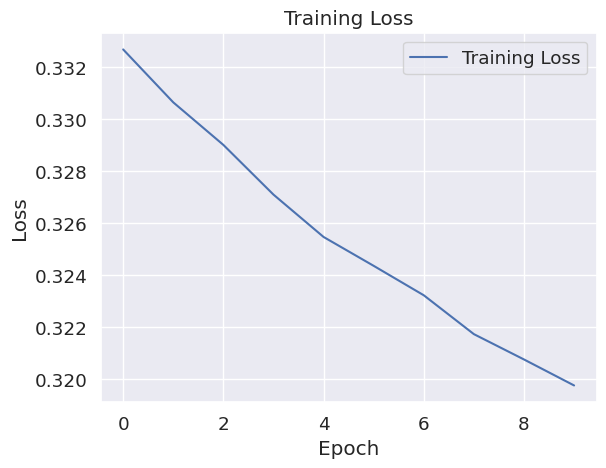

In [236]:
train_model(model, train_loader, criterion, optimizer, num_epochs)

In [237]:
y_true, y_pred, test_accuracy = evaluate_model(model, test_loader, device)

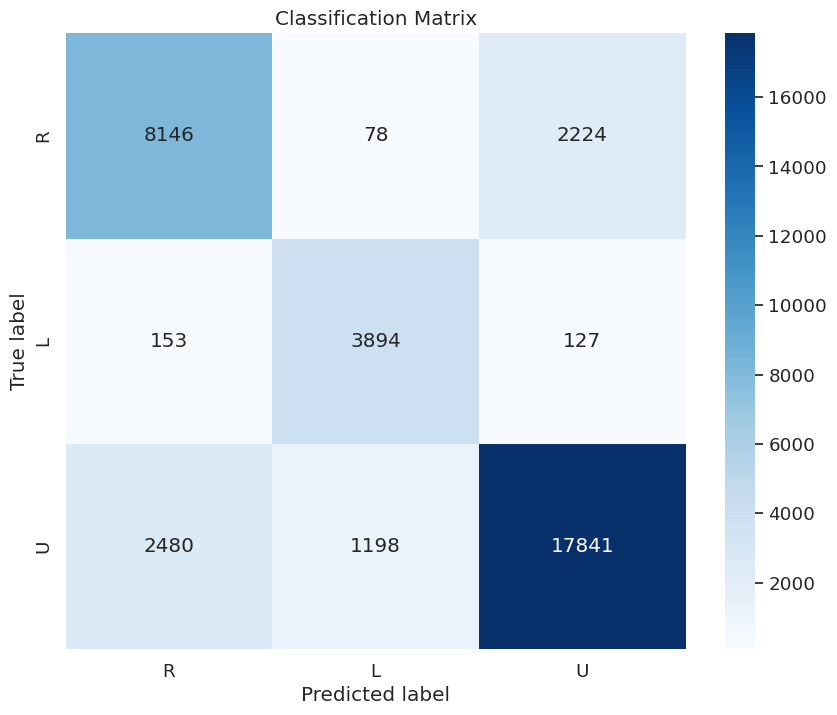

In [238]:
 plot_classification_matrix(y_true, y_pred, labels=['R', 'L', 'U'])

In [239]:
print_classification_report(y_true, y_pred, labels=['R', 'L', 'U'])

              precision    recall  f1-score   support

           R       0.76      0.78      0.77     10448
           L       0.75      0.93      0.83      4174
           U       0.88      0.83      0.86     21519

    accuracy                           0.83     36141
   macro avg       0.80      0.85      0.82     36141
weighted avg       0.83      0.83      0.83     36141

